Isotropic Total Variation
=========================

This example demonstrates isotropic total variation (TV) regularization.
It solves the denosing problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x} \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient vectors at each point in the image $\mathbf{x}$.
The same reconstruction is performed with anisotropic TV regularization for comparison;
the isotropic version shows fewer block-like artifacts.

In SCICO, switching between these two regularizers is a one-line change:
replacing an [L1Norm](../_autosummary/scico.functional.rst#scico.functional.L1Norm) with a [L21Norm](../_autosummary/scico.functional.rst#scico.functional.L21Norm).

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from scico import functional, linop, loss, plot
from scico.admm import ADMM, LinearSubproblemSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # Image size

# these steps create a ground truth image by spatially filtering noise
kernel_size = N // 5
key = jax.random.PRNGKey(1)
x_gt = jax.random.uniform(key, shape=(N + kernel_size - 1, N + kernel_size - 1))
x = jnp.linspace(-3, 3, kernel_size)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
window = window / window.sum()
x_gt = jsp.signal.convolve(x_gt, window, mode="valid")
x_gt = (x_gt > jnp.percentile(x_gt, 25)).astype(float) + (x_gt > jnp.percentile(x_gt, 75)).astype(
    float
)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
sigma = 1.0  # noise standard deviation
key, subkey = jax.random.split(key)

n = sigma * jax.random.normal(subkey, shape=x_gt.shape)

y = x_gt + n

Denoise with isotropic total variation

In [4]:
reg_weight_iso = 2e0
f = loss.SquaredL2Loss(y=y)
g_iso = reg_weight_iso * functional.L21Norm()

# the append=0 option makes the results of horizontal and vertical finite differences
# the same shape, which is required for the L21Norm
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

solver.solve()

x_iso = solver.x

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  2.025e+05    5.106e+01  1.059e+02
   1  1.841e+05    4.301e+00  1.003e+02
   2  1.646e+05    4.233e+00  9.701e+01


   3  1.466e+05    4.915e+00  9.344e+01
   4  1.300e+05    5.615e+00  8.955e+01
   5  1.150e+05    6.206e+00  8.536e+01
   6  1.015e+05    6.733e+00  8.089e+01
   7  8.947e+04    7.014e+00  7.621e+01
   8  7.894e+04    7.411e+00  7.125e+01


   9  6.986e+04    7.684e+00  6.605e+01
  10  6.219e+04    7.914e+00  6.065e+01
  11  5.584e+04    8.023e+00  5.506e+01
  12  5.070e+04    7.951e+00  4.950e+01
  13  4.662e+04    7.653e+00  4.403e+01
  14  4.348e+04    7.446e+00  3.871e+01
  15  4.112e+04    7.004e+00  3.362e+01


  16  3.938e+04    6.429e+00  2.898e+01
  17  3.811e+04    5.802e+00  2.479e+01
  18  3.721e+04    5.235e+00  2.099e+01
  19  3.658e+04    4.602e+00  1.777e+01
  20  3.614e+04    4.021e+00  1.508e+01
  21  3.585e+04    3.583e+00  1.268e+01
  22  3.566e+04    3.149e+00  1.063e+01


  23  3.553e+04    2.756e+00  8.910e+00
  24  3.545e+04    2.391e+00  7.461e+00
  25  3.540e+04    2.131e+00  6.229e+00
  26  3.537e+04    1.840e+00  5.244e+00
  27  3.536e+04    1.617e+00  4.463e+00


  28  3.535e+04    1.427e+00  3.764e+00
  29  3.535e+04    1.305e+00  3.170e+00
  30  3.535e+04    1.136e+00  2.701e+00
  31  3.536e+04    1.048e+00  2.262e+00
  32  3.536e+04    9.495e-01  1.902e+00


  33  3.537e+04    8.565e-01  1.563e+00
  34  3.537e+04    8.056e-01  1.209e+00
  35  3.538e+04    7.303e-01  8.882e-01
  36  3.538e+04    6.351e-01  7.826e-01
  37  3.539e+04    5.792e-01  6.930e-01
  38  3.539e+04    5.443e-01  6.072e-01


  39  3.540e+04    5.164e-01  4.928e-01
  40  3.540e+04    4.723e-01  4.499e-01
  41  3.540e+04    4.448e-01  4.119e-01
  42  3.541e+04    4.197e-01  3.794e-01
  43  3.541e+04    3.966e-01  3.506e-01
  44  3.541e+04    3.750e-01  3.247e-01
  45  3.541e+04    3.559e-01  2.912e-01


  46  3.542e+04    3.401e-01  2.527e-01
  47  3.542e+04    3.240e-01  2.249e-01
  48  3.542e+04    3.082e-01  2.057e-01
  49  3.542e+04    2.933e-01  1.908e-01
  50  3.542e+04    2.798e-01  1.770e-01
  51  3.543e+04    2.674e-01  1.652e-01
  52  3.543e+04    2.562e-01  1.547e-01


  53  3.543e+04    2.457e-01  1.457e-01
  54  3.543e+04    2.356e-01  1.380e-01
  55  3.543e+04    2.262e-01  1.305e-01
  56  3.543e+04    2.174e-01  1.232e-01
  57  3.543e+04    2.089e-01  1.174e-01
  58  3.543e+04    2.007e-01  1.127e-01
  59  3.544e+04    1.931e-01  1.078e-01


  60  3.544e+04    1.862e-01  1.015e-01
  61  3.544e+04    1.797e-01  9.482e-02
  62  3.544e+04    1.736e-01  8.900e-02
  63  3.544e+04    1.678e-01  8.396e-02
  64  3.544e+04    1.620e-01  7.983e-02
  65  3.544e+04    1.564e-01  7.595e-02
  66  3.544e+04    1.510e-01  7.329e-02


  67  3.544e+04    1.460e-01  7.082e-02
  68  3.544e+04    1.412e-01  6.855e-02
  69  3.544e+04    1.365e-01  6.665e-02
  70  3.544e+04    1.321e-01  6.397e-02
  71  3.544e+04    1.283e-01  6.009e-02
  72  3.544e+04    1.247e-01  5.624e-02
  73  3.544e+04    1.210e-01  5.373e-02


  74  3.544e+04    1.174e-01  5.197e-02
  75  3.544e+04    1.139e-01  5.002e-02
  76  3.544e+04    1.107e-01  4.817e-02
  77  3.545e+04    1.076e-01  4.629e-02
  78  3.545e+04    1.045e-01  4.487e-02
  79  3.545e+04    1.014e-01  4.345e-02
  80  3.545e+04    9.865e-02  4.120e-02


  81  3.545e+04    9.596e-02  3.950e-02
  82  3.545e+04    9.348e-02  3.733e-02
  83  3.545e+04    9.106e-02  3.554e-02
  84  3.545e+04    8.888e-02  3.373e-02
  85  3.545e+04    8.683e-02  3.238e-02
  86  3.545e+04    8.482e-02  3.165e-02
  87  3.545e+04    8.291e-02  3.074e-02


  88  3.545e+04    8.107e-02  2.975e-02
  89  3.545e+04    7.933e-02  2.843e-02
  90  3.545e+04    7.764e-02  2.741e-02
  91  3.545e+04    7.593e-02  2.630e-02
  92  3.545e+04    7.431e-02  2.491e-02
  93  3.545e+04    7.275e-02  2.373e-02
  94  3.545e+04    7.127e-02  2.274e-02


  95  3.545e+04    6.973e-02  2.240e-02
  96  3.545e+04    6.829e-02  2.183e-02
  97  3.545e+04    6.693e-02  2.149e-02
  98  3.545e+04    6.560e-02  2.128e-02
  99  3.545e+04    6.439e-02  2.075e-02


Denoise with anisotropic total variation for comparison.

In [5]:
# we tune the weight to give the same data fidelty as the isotropic case
reg_weight_aniso = 1.74e0
g_aniso = reg_weight_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

solver.solve()

x_aniso = solver.x

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  2.196e+05    6.090e+01  1.236e+02
   1  1.974e+05    9.715e+00  1.161e+02
   2  1.728e+05    1.055e+01  1.103e+02
   3  1.507e+05    1.097e+01  1.043e+02
   4  1.309e+05    1.102e+01  9.830e+01


   5  1.135e+05    1.102e+01  9.215e+01
   6  9.825e+04    1.100e+01  8.590e+01
   7  8.509e+04    1.098e+01  7.951e+01
   8  7.391e+04    1.090e+01  7.301e+01
   9  6.467e+04    1.087e+01  6.623e+01


  10  5.719e+04    1.064e+01  5.939e+01
  11  5.131e+04    1.026e+01  5.250e+01
  12  4.680e+04    9.629e+00  4.592e+01
  13  4.342e+04    8.922e+00  3.975e+01
  14  4.096e+04    8.126e+00  3.403e+01
  15  3.918e+04    7.209e+00  2.889e+01


  16  3.793e+04    6.388e+00  2.436e+01
  17  3.707e+04    5.615e+00  2.040e+01
  18  3.648e+04    4.779e+00  1.725e+01
  19  3.607e+04    4.119e+00  1.462e+01
  20  3.580e+04    3.589e+00  1.239e+01


  21  3.562e+04    3.196e+00  1.041e+01
  22  3.551e+04    2.762e+00  8.655e+00
  23  3.544e+04    2.499e+00  7.127e+00
  24  3.539e+04    2.056e+00  6.087e+00
  25  3.537e+04    1.797e+00  5.254e+00
  26  3.536e+04    1.609e+00  4.449e+00


  27  3.535e+04    1.439e+00  3.721e+00
  28  3.535e+04    1.301e+00  3.129e+00
  29  3.535e+04    1.159e+00  2.650e+00
  30  3.536e+04    1.049e+00  2.246e+00
  31  3.536e+04    9.522e-01  1.860e+00


  32  3.537e+04    8.667e-01  1.547e+00
  33  3.537e+04    8.025e-01  1.225e+00
  34  3.538e+04    7.066e-01  1.069e+00
  35  3.538e+04    6.369e-01  1.001e+00
  36  3.539e+04    5.923e-01  9.025e-01


  37  3.539e+04    5.536e-01  7.998e-01
  38  3.539e+04    5.161e-01  7.333e-01
  39  3.539e+04    4.771e-01  6.903e-01
  40  3.540e+04    4.480e-01  6.488e-01
  41  3.540e+04    4.283e-01  5.693e-01
  42  3.540e+04    4.047e-01  5.142e-01
  43  3.541e+04    3.818e-01  4.770e-01


  44  3.541e+04    3.602e-01  4.470e-01
  45  3.541e+04    3.411e-01  4.195e-01
  46  3.541e+04    3.228e-01  3.962e-01
  47  3.541e+04    3.060e-01  3.758e-01
  48  3.541e+04    2.909e-01  3.557e-01


  49  3.541e+04    2.768e-01  3.372e-01
  50  3.541e+04    2.637e-01  3.191e-01
  51  3.542e+04    2.511e-01  3.033e-01
  52  3.542e+04    2.395e-01  2.885e-01
  53  3.542e+04    2.289e-01  2.734e-01
  54  3.542e+04    2.187e-01  2.591e-01


  55  3.542e+04    2.091e-01  2.457e-01
  56  3.542e+04    1.994e-01  2.342e-01
  57  3.542e+04    1.901e-01  2.242e-01
  58  3.542e+04    1.816e-01  2.147e-01
  59  3.542e+04    1.739e-01  2.055e-01
  60  3.542e+04    1.669e-01  1.960e-01
  61  3.542e+04    1.606e-01  1.866e-01


  62  3.542e+04    1.543e-01  1.780e-01
  63  3.542e+04    1.486e-01  1.695e-01
  64  3.542e+04    1.434e-01  1.606e-01
  65  3.542e+04    1.382e-01  1.526e-01
  66  3.543e+04    1.334e-01  1.454e-01
  67  3.543e+04    1.290e-01  1.379e-01


  68  3.543e+04    1.247e-01  1.310e-01
  69  3.543e+04    1.206e-01  1.241e-01
  70  3.543e+04    1.169e-01  1.178e-01
  71  3.543e+04    1.128e-01  1.136e-01
  72  3.543e+04    1.087e-01  1.102e-01


  73  3.543e+04    1.050e-01  1.060e-01
  74  3.543e+04    1.015e-01  1.023e-01
  75  3.543e+04    9.795e-02  9.930e-02
  76  3.543e+04    9.466e-02  9.625e-02


  77  3.543e+04    9.154e-02  9.309e-02
  78  3.543e+04    8.846e-02  9.014e-02
  79  3.543e+04    8.547e-02  8.748e-02
  80  3.543e+04    8.264e-02  8.468e-02
  81  3.543e+04    8.010e-02  8.109e-02


  82  3.543e+04    7.770e-02  7.731e-02
  83  3.543e+04    7.553e-02  7.352e-02
  84  3.543e+04    7.338e-02  7.030e-02
  85  3.543e+04    7.137e-02  6.768e-02
  86  3.543e+04    6.926e-02  6.527e-02


  87  3.543e+04    6.720e-02  6.312e-02
  88  3.543e+04    6.521e-02  6.094e-02
  89  3.543e+04    6.349e-02  5.884e-02
  90  3.543e+04    6.175e-02  5.711e-02
  91  3.543e+04    5.994e-02  5.597e-02


  92  3.543e+04    5.816e-02  5.512e-02
  93  3.543e+04    5.644e-02  5.388e-02
  94  3.543e+04    5.485e-02  5.273e-02
  95  3.543e+04    5.327e-02  5.136e-02
  96  3.543e+04    5.189e-02  4.962e-02


  97  3.543e+04    5.068e-02  4.754e-02
  98  3.543e+04    4.948e-02  4.570e-02
  99  3.543e+04    4.845e-02  4.351e-02


Compute the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("isotropic", "anisotropic")):
    df = f(x)
    print(f"data fidelity for {name} TV was {df:.2e}")

data fidelity for isotropic TV was 3.33e+04
data fidelity for anisotropic TV was 3.33e+04


Plot results.

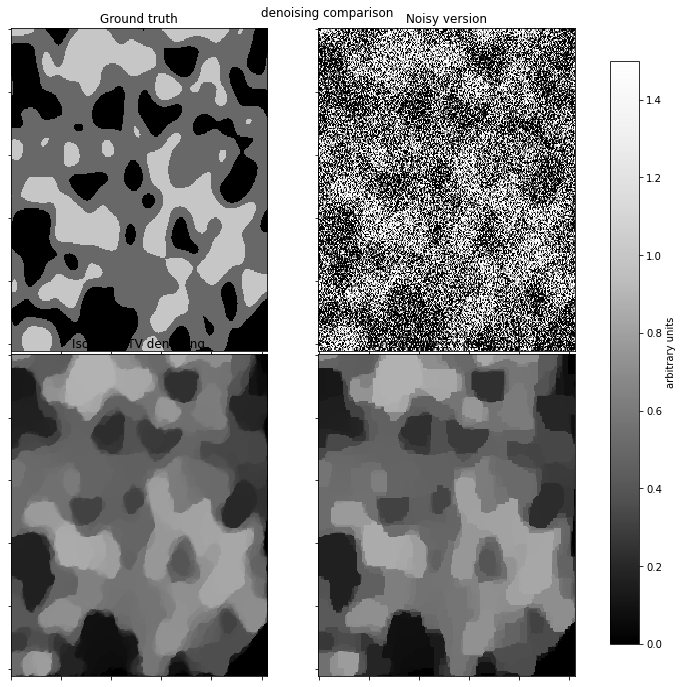

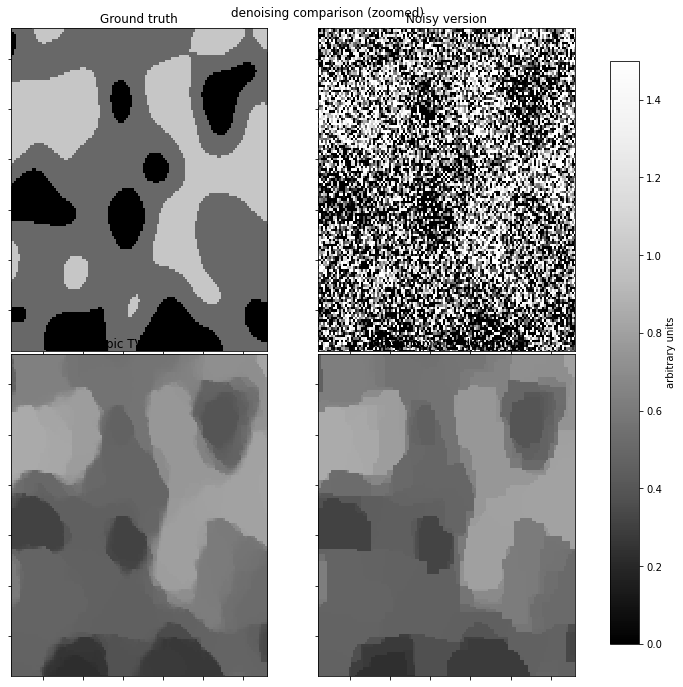

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.suptitle("denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.suptitle("denoising comparison (zoomed)")
fig.show()